In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import pickle
import sklearn
from sklearn.utils import class_weight
import time
from sklearn import metrics
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
%run SharedFunctions.ipynb

Učitava se prethodno pripremljen skup podataka: 

In [5]:
data = pd.read_csv('data/data_longer.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)

In [6]:
data.shape

(223453, 9)

### 1. Podela na trening, test, i validacioni skup

In [7]:
# Ovo je prepisano iz prethodne sveske

train_size = 159571 - 96
test_size = 63978
validation_size = int(0.2*train_size)
train_size = train_size - validation_size

validation_data = data[:validation_size]
train_data = data[validation_size:train_size+validation_size]
test_data = data[train_size+validation_size : ]

train_data.shape[0], test_data.shape[0], validation_data.shape[0]

(127580, 63978, 31895)

### 2. Tokenizacija I vektorizacija teksta

In [8]:
# uzima se recimo 20000 najfrekventinijh reci
max_features = 20000

# max duzina
max_len = 100

In [9]:
word_index, tokenizer = get_vocabulary(max_features, train_data, 'tokenizer_binary.pickle')

In [10]:
print('Broj jedinstvenih reci:', len(word_index))

Broj jedinstvenih reci: 187048


Sada pravimo skupove za trening, test i validaciju sa vektorizovanim tekstom

In [11]:
X_train = to_sequence(train_data['comment_text'], max_len, tokenizer)
X_test = to_sequence(test_data['comment_text'], max_len, tokenizer)
X_validation = to_sequence(validation_data['comment_text'], max_len, tokenizer)

In [12]:
X_train.shape, X_test.shape, X_validation.shape

((127580, 100), (63978, 100), (31895, 100))

In [13]:
y_train = train_data['target']
y_test = test_data['target']
y_validation = validation_data['target']

Kreira se matrica ugnjezdavanja

In [14]:
embedding_matrix = create_embedding_matrix(word_index, max_len)

In [15]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.18970001,  0.050024  ,  0.19084001, ..., -0.39804   ,
         0.47646999, -0.15983   ],
       ...,
       [-0.25132999, -0.38620001,  0.37869999, ...,  0.031966  ,
        -0.27360001, -0.96281999],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.085656  , -0.22007   ,  0.75664997, ...,  0.73556   ,
         0.65118998, -0.23041999]])

### 3. Formiranje modela

In [17]:
kernel_size = 3
pool_size = 3
filters = 32
dropout_rate = 0.4

In [18]:
binary_model = create_model(num_of_classes = 2, num_of_features = max_features, embedding_dim = 100, 
                kernel_size = kernel_size, pool_size = pool_size, filters = filters, 
                dropout_rate = dropout_rate, maxlen = max_len, embedding_matrix = embedding_matrix)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 32)           9632      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 33, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 33, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 32)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0

In [19]:
lr = 0.001

binary_model.compile(loss='binary_crossentropy', optimizer=Adam(lr), metrics=[f1_m, recall_m, precision_m])

### 4. Obučavanje modela

In [20]:
weights = get_weights(y_train)
weights

{0: 0.5563210772343543, 1: 4.9388355528027255}

In [21]:
epochs = 10
batch_size = 128

In [22]:
start = time.time()    

binary_history = binary_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                                 validation_data=(X_validation, y_validation), class_weight=weights)
                                 #,callbacks=[early_stop]
                                 
print('Trajanje obucavanja modela binarne klasifikacije: ', time.time() - start)

Epoch 1/10
997/997 [==============================] - 33s 33ms/step - loss: 0.3789 - f1_m: 0.5507 - recall_m: 0.8357 - precision_m: 0.4278 - val_loss: 0.3190 - val_f1_m: 0.6263 - val_recall_m: 0.8756 - val_precision_m: 0.4955
Epoch 2/10
997/997 [==============================] - 32s 32ms/step - loss: 0.2944 - f1_m: 0.6463 - recall_m: 0.8558 - precision_m: 0.5326 - val_loss: 0.2874 - val_f1_m: 0.6490 - val_recall_m: 0.8814 - val_precision_m: 0.5215call_m: 0.8541 - precision_m: 0.5 - ETA: 3s - loss: 0.2978 - f1_m: 0.6453 - recall_m: 0.8540 - precision_m: 0 - ETA: 3s - loss: 0.2976 -
Epoch 3/10
997/997 [==============================] - 33s 33ms/step - loss: 0.2712 - f1_m: 0.6641 - recall_m: 0.8669 - precision_m: 0.5507 - val_loss: 0.2643 - val_f1_m: 0.6691 - val_recall_m: 0.8823 - val_precision_m: 0.5467
Epoch 4/10
997/997 [==============================] - 32s 32ms/step - loss: 0.2567 - f1_m: 0.6751 - recall_m: 0.8771 - precision_m: 0.5615 - val_loss: 0.2441 - val_f1_m: 0.6821 - val_rec

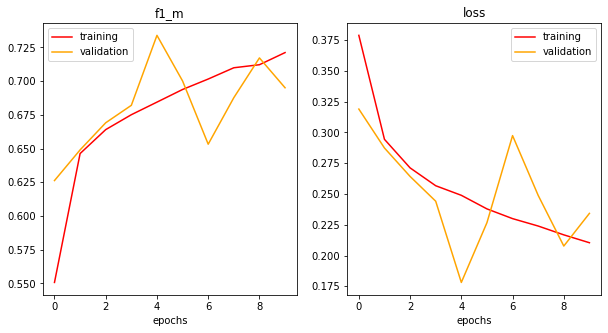

In [30]:
plot_graphs(binary_history, ['f1_m', 'loss'])

### 5. Evaluacija modela

In [24]:
scores = binary_model.evaluate(X_test, y_test)

2000/2000 [==============================] - 9s 5ms/step - loss: 0.4976 - f1_m: 0.5210 - recall_m: 0.8930 - precision_m: 0.3883


In [25]:
y_pred = binary_model.predict(X_test)

In [45]:
positives = y_pred[y_pred > 0.5]
positives

new_class = [int(score > 0.5) for score in y_pred]


In [46]:
cf = metrics.confusion_matrix(y_test, new_class)

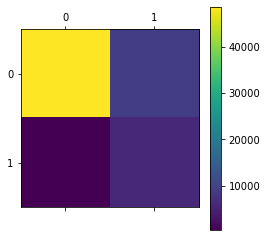

In [47]:
plt.matshow(cf)
plt.colorbar()
plt.show()

In [49]:
print(cf)

[[48616  9115]
 [  453  5794]]
